# Goal: Implement a Logistic Regression on Hemorrhage Data

In [276]:
#Import Modules
import numpy as np
import os
import pydicom
import cv2
import matplotlib.pyplot as plt
import csv
import pandas as pd
from os.path import isfile, join
from sklearn.model_selection import train_test_split



In [277]:
#Import all of the labeling data into a Pandas Dataframe
train = pd.read_csv("H:/CS230_Project/CS-230-Hemorrhage/rsna-intracranial-hemorrhage-detection/stage_1_train.csv")

In [278]:
#Check to make sure the data was imported correctly
train.head(6)

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0
5,ID_63eb1e259_any,0


In [279]:
#Since each of our images has 6 labels, this should give us the number of images
int(train.shape[0]/6)

674262

In [280]:
#This Function takes in an image ID and it returns the flattened pixel data 
def open_image(image_ID):
    #Get image from source
    img_dir = "H:/CS230_Project/CS-230-Hemorrhage/rsna-intracranial-hemorrhage-detection/stage_1_train_images/" + image_ID + ".dcm"
    ds = pydicom.dcmread(img_dir)
    ds_array = ds.pixel_array
    
    #image_2d = ds_array.astype(float)
    #image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
    
    ds_array = cv2.resize(ds_array, dsize=(128,128), interpolation=cv2.INTER_CUBIC)
    image_flat = ds_array.reshape((1,ds_array.shape[0]*ds_array.shape[1]))
    
    #Generate Image
    #plt.imshow(ds_array)
    #print (np.amin(image_flat))
    #print (np.amax(image_flat))

    return image_flat


In [281]:
#Test of the function to make sure it is working properly
open_image(image_ID="ID_63eb1e259")


array([[31, 26, 23, ..., 22, 21, 22]], dtype=uint16)

In [282]:
#Build Dataset
train_size = 10000   #This is the number of pictures we want to have in the training set

image_info = []   
old_id = ""
Y = np.empty([train_size,6])              #Initailize Y
X = np.empty([train_size,16384])          #Initailize X
Image_Names_Sorted = []
for i,row in train[:train_size*6].iterrows():
    image_ID = row["ID"][:12]
    if (i==0):
        old_id = row["ID"][:12]
    if(image_ID ==old_id):
        image_info.append(int(row["Label"]))
    else:
        j = int((i)/6-1)
        Y[j] = image_info
        X[j] = open_image(image_ID)
        Image_Names_Sorted.append(image_ID) 
        image_info = []
        image_info.append(int(row["Label"]))
        old_id = image_ID
    if (i==train_size*6-1):
        j = int((i+1)/6-1)
        Y[j] = image_info
        X[j] = open_image(image_ID)
        Image_Names_Sorted.append(image_ID)
    

In [283]:
print (X.shape)

(10000, 16384)


In [284]:
print (Y.shape)

(10000, 6)


In [285]:
print (len(Image_Names_Sorted))

10000


In [286]:
#Normalizing Inputs:
def normalize(X_prev):
    u = np.mean(X_prev)
    var = np.var(X_prev)
    X = (X_prev - u)/var
    return X

In [287]:
X_Test = normalize(X)

In [288]:
print (X_Test)

[[-0.00029154 -0.00029403 -0.00029278 ...  0.00017943  0.00028257
   0.00032979]
 [-0.00157893 -0.00157893 -0.00157893 ... -0.00157893 -0.00157893
  -0.00157893]
 [-0.00027663 -0.0002816  -0.00027787 ... -0.00027663 -0.00027911
  -0.00028036]
 ...
 [-0.00027042 -0.00026917 -0.00027042 ... -0.00018592 -0.0001797
  -0.0002058 ]
 [-0.00027539 -0.00027539 -0.00027539 ... -0.00027663 -0.00027911
  -0.00027663]
 [-0.00027539 -0.00027539 -0.00027539 ... -0.00027663 -0.00027911
  -0.00027663]]


In [289]:
X = normalize(X)

In [290]:
# Splitting the Data into test and train:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [291]:
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

# Linear Regression:

In [292]:
# Lets make some functions!
def initialize_with_zeros(dim):
    w = np.zeros([dim,6]) #w.shape = (m,6)
    b = np.zeros([6,1])
    
    return w, b

In [303]:
def propagate(w,b,X,Y):
    m = X.shape[1]
    #print (w[1][1])
    
    Z = np.dot(w.T,X)+b
    #print (Z)
    #print (w.T)
    A = 1/(1+np.exp(-Z))
    loss = Y*(np.log(A))+(1-Y)*(np.log(1-A))# (Y-A)*(Y-A)
    #print (loss)
    cost = -np.sum(loss)/m
    
    dZ = A-Y
    #print (dZ)
    dw = (1/m)*np.dot(X,dZ.T)
    #print (dw)
    db = (1/m)*np.sum(dZ,axis = 1, keepdims=True)
    #print (db)
    
    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [304]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        #print (w)
        #print (b)
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        #print (db)
        # update rule
        w = w - learning_rate*dw
        #print (w)
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [305]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 6)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    Z = np.dot(w.T,X)+b
    A = 1/(1+np.exp(-Z))
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0,i] <=.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [308]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.0001, print_cost = False):
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    print (w)
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    print (np.sum(Y_prediction_test))

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
    

In [309]:
d = model(X_train, Y_train, X_test, Y_test, num_iterations = 400, learning_rate = 0.05, print_cost = True)    

Cost after iteration 0: 4.158883
Cost after iteration 100: 1.859401
Cost after iteration 200: 1.484245
Cost after iteration 300: 1.367451
[[0.00367732 0.003114   0.00322875 0.00306713 0.00291482 0.00211825]
 [0.0036773  0.00311372 0.00322876 0.00306665 0.00291491 0.00211818]
 [0.0036776  0.0031135  0.00322896 0.00306656 0.00291523 0.00211786]
 ...
 [0.00357183 0.00301114 0.00312797 0.00299646 0.00283866 0.00205849]
 [0.00357425 0.00301554 0.00312873 0.00299367 0.00283492 0.00205082]
 [0.00357343 0.00301611 0.00312408 0.00298315 0.00282619 0.00203514]]
0.0
train accuracy: 94.05952380952381 %
test accuracy: 94.2611111111111 %


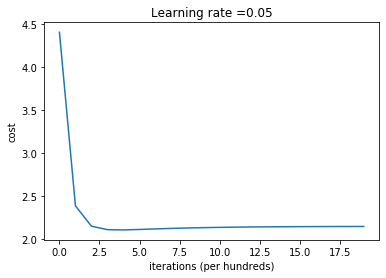

In [298]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()